In [1]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib
import matplotlib.pyplot as plt
import time
import os
import math
from math import exp, pi,sin,cos

np.random.seed(1)
tf.set_random_seed(1)
###########设置定义域范围

a = 0
b = 1
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, layers_U, layers_V1,layers_V2,layers_V3,layers_V4, layers_LM, x_range, f, num_train_tps):

        # Initialize NNs
        self.layers_U = layers_U
        self.weights_U, self.biases_U, self.adaps_U = self.initialize_NN(layers_U)
        self.layers_V1 = layers_V1
        self.weights_V1, self.biases_V1, self.adaps_V1 = self.initialize_NN(layers_V1)
        self.layers_V2 = layers_V2
        self.weights_V2, self.biases_V2, self.adaps_V2 = self.initialize_NN(layers_V2)
        self.layers_V3 = layers_V3
        self.weights_V3, self.biases_V3, self.adaps_V3 = self.initialize_NN(layers_V3)
        self.layers_V4 = layers_V4
        self.weights_V4, self.biases_V4, self.adaps_V4 = self.initialize_NN(layers_V4)
        self.layers_LM = layers_LM
        self.weights_LM, self.biases_LM, self.adaps_LM = self.initialize_NN(layers_LM)

        # Parameters
        self.x_range =x_range
        self.lb = np.array([ x_range[0]])
        self.ub = np.array([ x_range[1]])
        # Output file
        self.f = f
        self.xx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.ux_star_tf = tf.placeholder(tf.float32, shape=[None, 1])
        # Test Points                           ######################测试点
        self.x_test_tf = tf.placeholder(tf.float32, shape=[None, 1])

        # Generate Training and Testing Points  ########################生成训练和测试点
        self.generateTrain(num_train_tps)

        # Physics
        self.f, self.e1, self.e2, self.e3,self.e4, self.Ux, self.V1x, self.V2x, self.V3x,self.V4x, self.U_xx, self.V1_xx, self.V2_xx, self.V3_xx, self.V4_xx, self.V1ex, self.V2ex, self.V3ex,  self.V4ex, self.LMx, self.LM_xx = self.pinn(
            self.xx_tf)
        self.f, self.e1,self.e2,self.e3,self.e4, self.Uf, self.V1f,self.V2f,self.V3f,self.V4f,self.U_xf,self.V1_xf,self.V2_xf,self.V3_xf,self.V4_xf,self.V1e,self.V2e,self.V3e,self.V4e,self.LMf, self.LM_xf= self.pinn(self.xf)
        _,_,_,_,_,self.Ui, self.V1i,self.V2i,self.V3i,self.V4i,_,_,_,_,_,_,_,_,_,_,_= self.pinn(self.xi)
        _,_,_,_,_,_,_,_,_,_,_,_,_,_,_,self.V1e,self.V2e,self.V3e,self.V4e,_,_= self.pinn(self.xe)
        self.f_test,  self.e1_test, self.e2_test,self.e3_test,self.e4_test,self.U_test, self.V1_test,self.V2_test,self.V3_test,self.V4_test,self.U_x_test,self.V1_x_test,self.V2_x_test,self.V3_x_test,self.V4_x_test,_,_,_,_, self.LM_test,self.LM_xtest= self.pinn(self.x_test_tf)

        self.loss_U = tf.reduce_mean((self.Ux - self.ux_star_tf) ** 2)
        self.loss_LM = tf.reduce_mean((self.LM_xf - 0 * self.Uf) ** 2)
        self.loss_f = tf.reduce_mean((self.U_xf+self.LMf*(-(self.xf+2)*self.V1f-self.xf*(self.xf+2)*self.V2f-0.5*self.xf**2*(self.xf+2)*self.V3f-self.xf**3*(self.xf+2)*self.V4f/6)-2*tf.exp(2*self.xf)-1.0+tf.exp(self.xf**2+2*self.xf))** 2)
        self.loss_e1 = tf.reduce_mean((self.V1_xf -self.Uf)** 2)
        self.loss_e2 = tf.reduce_mean((self.V2_xf - self.xf*self.Uf) ** 2)
        self.loss_e3 = tf.reduce_mean((self.V3_xf -self.xf**2*self.Uf) ** 2)
        self.loss_e4 = tf.reduce_mean((self.V4_xf - self.xf ** 3 * self.Uf) ** 2)
        self.loss_i= tf.reduce_mean((self.Ui-1) ** 2)+tf.reduce_mean((self.V1i-0) ** 2)\
                     +tf.reduce_mean((self.V2i-0) ** 2)+tf.reduce_mean((self.V3i-0) ** 2)+tf.reduce_mean((self.V3i-0) ** 2)


        # # Total Loss
        self.loss =self.loss_U*10+self.loss_LM*100+ self.loss_f *0.1+ self.loss_e1*1+ self.loss_e2*1 +self.loss_e3*1+self.loss_e4*1+self.loss_i*1


        # Optimizer
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        self.sess = tf.Session()
        init = tf.global_variables_initializer()
        self.sess.run(init)

#####################初始化神经网络参数
    def initialize_NN(self, layers):
        weights = []
        biases = []
        adaps = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            a = tf.Variable(1.0, dtype=tf.float32)
            weights.append(W)
            biases.append(b)
            adaps.append(a)
        return weights, biases, adaps

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def net_U(self, X):
        weights = self.weights_U
        biases = self.biases_U
        adaps = self.adaps_U
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        U = tf.add(tf.matmul(h, W), b)
        return U

    def net_V1(self, X):
        weights = self.weights_V1
        biases = self.biases_V1
        adaps = self.adaps_V1
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V1 = tf.add(tf.matmul(h, W), b)
        return V1
    def net_V2(self, X):
        weights = self.weights_V2
        biases = self.biases_V2
        adaps = self.adaps_V2
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V2= tf.add(tf.matmul(h, W), b)
        return V2
    def net_V3(self, X):
        weights = self.weights_V3
        biases = self.biases_V3
        adaps = self.adaps_V3
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V3 = tf.add(tf.matmul(h, W), b)
        return V3

    def net_V4(self, X):
        weights = self.weights_V4
        biases = self.biases_V4
        adaps = self.adaps_V4
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V4 = tf.add(tf.matmul(h, W), b)
        return V4
    def net_LM(self, X):
        weights = self.weights_LM
        biases = self.biases_LM
        adaps = self.adaps_LM
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        LM = tf.add(tf.matmul(h, W), b)
        return LM
    #
    def pinn(self,x):
        X=x
        # x=self.x_range[1] * tf.ones(x.shape)
        U = self.net_U(X)
        V1 =self.net_V1(X)
        V2 =self.net_V2(X)
        V3= self.net_V3(X)
        V4 = self.net_V4(X)
        V1e = self.net_V1(X)
        V2e= self.net_V2(X)
        V3e = self.net_V3(X)
        V4e = self.net_V4(X)
        LM = self.net_LM(X)


        U_x = tf.gradients(U, x)  # du/dx
        V1_x = tf.gradients(V1, x)  # dv1/dx
        V2_x = tf.gradients(V2, x)  # dv2dx
        V3_x = tf.gradients(V3, x)  # dv3/dx
        V4_x = tf.gradients(V4, x)
        LM_x = tf.gradients(LM, x)  # dLM/dx

        f = U_x+LM*(-(x+2)*V1-x*(x+2)*V2-0.5*x**2*(x+2)*V3-x**3*(x+2)*V4/6)-2*tf.exp(2*x)-1.0+tf.exp(x**2+2*x)
        e1 =V1_x-U
        e2 = V2_x-x*U
        e3 =V3_x -x**2* U
        e4 = V4_x - x ** 3 * U


        return f,e1,e2,e3,e4,U,V1,V2,V3,V4, U_x ,V1_x,V2_x,V3_x,V4_x,V1e,V2e,V3e,V4e, LM, LM_x


    def generateTrain(self, num_train_tps):
        xf = tf.linspace(np.float32(self.x_range[0]), np.float32(self.x_range[1]), 200)
        self.xf = tf.reshape(xf, [-1, 1])
        xi = self.x_range[0] * tf.ones(xf.shape)
        self.xi = tf.reshape(xi, [-1, 1])
        xe = self.x_range[1] * tf.ones(xf.shape)
        self.xe = tf.reshape(xe, [-1, 1])
        return

    def train(self, Xx,Ux, it, printloss):
        xx=Xx[:,0:1]
        xx = np.reshape(xx, [-1, 1])
        ux=Ux[:,0:1]
        ux = ux.reshape(-1, 1)

        tf_dict = {self.xx_tf: xx,self.ux_star_tf: ux}


        self.sess.run(self.train_op_Adam, tf_dict)

        loss_value, loss_value_U,loss_value_LM,loss_value_f,loss_value_e1,loss_value_e2,loss_value_e3,loss_value_e4,loss_value_i= self.sess.run(
            [self.loss, self.loss_U,self.loss_LM,self.loss_f,self.loss_e1,self.loss_e2,self.loss_e3,self.loss_e4,self.loss_i
             ], tf_dict)
        loss_value_array = [loss_value_U*10,loss_value_LM*100,loss_value_f*0.1,loss_value_e1*1,loss_value_e2*1,loss_value_e3*1,loss_value_e4*1,loss_value_i*1]
        np.set_printoptions(precision=6)
        content = it, loss_value
        print(content, flush=True)
        # self.f.write(content + "\n")
        return loss_value, loss_value_array

    def test(self, num_test_tps):
        x = np.linspace(self.x_range[0], self.x_range[1], num_test_tps)
        x_test = np.reshape(x, [-1, 1])
        tf_dict = {self.x_test_tf: x_test}
        U_test = self.sess.run(self.U_test, tf_dict)
        V1_test = self.sess.run(self.V1_test, tf_dict)
        V2_test = self.sess.run(self.V2_test, tf_dict)
        V3_test = self.sess.run(self.V3_test, tf_dict)
        V4_test = self.sess.run(self.V4_test, tf_dict)
        LM_test = self.sess.run(self.LM_test, tf_dict)
        U_test_x = tf.gradients(U_test, x_test)
        V1_test_x = tf.gradients(V1_test, x_test)
        V2_test_x = tf.gradients(V2_test, x_test)
        V3_test_x = tf.gradients(V3_test, x_test)
        V4_test_x = tf.gradients(V4_test, x_test)
        f_test = self.sess.run(self.f_test, tf_dict)
        e1_test = self.sess.run(self.e1_test, tf_dict)
        e2_test = self.sess.run(self.e2_test, tf_dict)
        e3_test = self.sess.run(self.e3_test, tf_dict)
        e4_test = self.sess.run(self.e4_test, tf_dict)
        return x_test, U_test, V1_test, V2_test,V3_test,V4_test,f_test,e1_test,e2_test,e3_test,e4_test,U_test_x,V1_test_x,V2_test_x,V3_test_x,V4_test_x,LM_test
def import_data(filepath):

    data =np.loadtxt("U_exact.txt", delimiter=None, converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0)
    Xx = data[:, 0:1]
    Ux = data[:,1:2]
    noise =0.01
    normal_data = np.random.normal(0, 1,Ux.shape)
    Ux =Ux * (1 + noise * normal_data)
    return Xx, Ux


(1, 176.50867)
(2, 172.91568)
(3, 169.47119)
(4, 166.15958)
(5, 162.96584)
(6, 159.87805)
(7, 156.88419)
(8, 153.97292)
(9, 151.1351)
(10, 148.36386)
(11, 145.65329)
(12, 142.99763)
(13, 140.39128)
(14, 137.82938)
(15, 135.30743)
(16, 132.82056)
(17, 130.36357)
(18, 127.9311)
(19, 125.51808)
(20, 123.119995)
(21, 120.73261)
(22, 118.352135)
(23, 115.97511)
(24, 113.598465)
(25, 111.21944)
(26, 108.83535)
(27, 106.443665)
(28, 104.04209)
(29, 101.62872)
(30, 99.20196)
(31, 96.76073)
(32, 94.30409)
(33, 91.831696)
(34, 89.34358)
(35, 86.84049)
(36, 84.323685)
(37, 81.795235)
(38, 79.25773)
(39, 76.71453)
(40, 74.16946)
(41, 71.626785)
(42, 69.0911)
(43, 66.56748)
(44, 64.061195)
(45, 61.577686)
(46, 59.122566)
(47, 56.701313)
(48, 54.319305)
(49, 51.98172)
(50, 49.693455)
(51, 47.45902)
(52, 45.282513)
(53, 43.16754)
(54, 41.11719)
(55, 39.133972)
(56, 37.219913)
(57, 35.37665)
(58, 33.60543)
(59, 31.90718)
(60, 30.28255)
(61, 28.732021)
(62, 27.255934)
(63, 25.854553)
(64, 24.528112)
(6

(500, 0.5491503)
(501, 0.54139817)
(502, 0.5335331)
(503, 0.525906)
(504, 0.51878184)
(505, 0.51187694)
(506, 0.5049193)
(507, 0.4981182)
(508, 0.4917024)
(509, 0.48548666)
(510, 0.4792737)
(511, 0.47320744)
(512, 0.46743822)
(513, 0.46182817)
(514, 0.45625162)
(515, 0.45082116)
(516, 0.44562298)
(517, 0.4405477)
(518, 0.4355278)
(519, 0.43064532)
(520, 0.42594418)
(521, 0.42134556)
(522, 0.41681355)
(523, 0.41240352)
(524, 0.4081387)
(525, 0.40396366)
(526, 0.39985752)
(527, 0.39585847)
(528, 0.39197755)
(529, 0.38817698)
(530, 0.38444498)
(531, 0.38080296)
(532, 0.37725988)
(533, 0.37379298)
(534, 0.3703887)
(535, 0.36706188)
(536, 0.3638186)
(537, 0.36064368)
(538, 0.35752907)
(539, 0.35447982)
(540, 0.35150233)
(541, 0.34858873)
(542, 0.34572938)
(543, 0.34292734)
(544, 0.34018597)
(545, 0.3375031)
(546, 0.3348707)
(547, 0.332288)
(548, 0.3297574)
(549, 0.32727945)
(550, 0.3248484)
(551, 0.3224623)
(552, 0.32012144)
(553, 0.31782576)
(554, 0.31557405)
(555, 0.3133639)
(556, 0.31119

(1383, 0.029031605)
(1384, 0.028831294)
(1385, 0.028726991)
(1386, 0.028719457)
(1387, 0.028729908)
(1388, 0.02866473)
(1389, 0.028510805)
(1390, 0.028321974)
(1391, 0.028177934)
(1392, 0.028104164)
(1393, 0.028065907)
(1394, 0.028012076)
(1395, 0.027919296)
(1396, 0.027805032)
(1397, 0.027695455)
(1398, 0.027604837)
(1399, 0.02752468)
(1400, 0.027441755)
(1401, 0.027352422)
(1402, 0.027263619)
(1403, 0.027182616)
(1404, 0.027106723)
(1405, 0.027028168)
(1406, 0.02694023)
(1407, 0.026845984)
(1408, 0.026753958)
(1409, 0.026671188)
(1410, 0.026597258)
(1411, 0.026525399)
(1412, 0.026448874)
(1413, 0.026365444)
(1414, 0.02627816)
(1415, 0.026192147)
(1416, 0.026110694)
(1417, 0.026033284)
(1418, 0.025957558)
(1419, 0.025880821)
(1420, 0.025802467)
(1421, 0.025723252)
(1422, 0.02564439)
(1423, 0.025566325)
(1424, 0.025488686)
(1425, 0.02541086)
(1426, 0.025332931)
(1427, 0.025255341)
(1428, 0.025178472)
(1429, 0.025102887)
(1430, 0.025028108)
(1431, 0.024953393)
(1432, 0.024878323)
(1433,

(1796, 0.008859791)
(1797, 0.008838647)
(1798, 0.008817073)
(1799, 0.008795065)
(1800, 0.0087729795)
(1801, 0.00875081)
(1802, 0.008728959)
(1803, 0.008707382)
(1804, 0.008686164)
(1805, 0.008665045)
(1806, 0.008644119)
(1807, 0.0086232275)
(1808, 0.008602284)
(1809, 0.008581344)
(1810, 0.00856042)
(1811, 0.008539613)
(1812, 0.008518864)
(1813, 0.008498273)
(1814, 0.008477752)
(1815, 0.008457357)
(1816, 0.008437073)
(1817, 0.008416813)
(1818, 0.0083966665)
(1819, 0.008376551)
(1820, 0.008356551)
(1821, 0.008336619)
(1822, 0.0083167385)
(1823, 0.008297004)
(1824, 0.008277387)
(1825, 0.00825778)
(1826, 0.00823839)
(1827, 0.008219063)
(1828, 0.008199964)
(1829, 0.008181001)
(1830, 0.008162451)
(1831, 0.0081442725)
(1832, 0.008126678)
(1833, 0.008109968)
(1834, 0.008094617)
(1835, 0.008081329)
(1836, 0.008071183)
(1837, 0.008066033)
(1838, 0.008068512)
(1839, 0.008083084)
(1840, 0.008115812)
(1841, 0.008176874)
(1842, 0.008276013)
(1843, 0.0084294425)
(1844, 0.008633612)
(1845, 0.008883452

(2198, 0.0041663838)
(2199, 0.0041616056)
(2200, 0.0041572233)
(2201, 0.0041533057)
(2202, 0.004150159)
(2203, 0.0041480325)
(2204, 0.0041474923)
(2205, 0.0041492055)
(2206, 0.004154513)
(2207, 0.004164859)
(2208, 0.004183226)
(2209, 0.0042126216)
(2210, 0.0042598993)
(2211, 0.0043299077)
(2212, 0.004436538)
(2213, 0.004581459)
(2214, 0.004784213)
(2215, 0.0050149783)
(2216, 0.005278841)
(2217, 0.005462774)
(2218, 0.005558634)
(2219, 0.005451287)
(2220, 0.0052374275)
(2221, 0.0049463026)
(2222, 0.0046832347)
(2223, 0.00445938)
(2224, 0.0043099825)
(2225, 0.004252777)
(2226, 0.0042806813)
(2227, 0.0043604937)
(2228, 0.0044222265)
(2229, 0.0044200392)
(2230, 0.004325441)
(2231, 0.004183349)
(2232, 0.0040675174)
(2233, 0.0040391535)
(2234, 0.004093518)
(2235, 0.0041672997)
(2236, 0.004194433)
(2237, 0.004145049)
(2238, 0.004053311)
(2239, 0.00397775)
(2240, 0.0039600893)
(2241, 0.003993305)
(2242, 0.004035516)
(2243, 0.0040475666)
(2244, 0.0040180725)
(2245, 0.0039693685)
(2246, 0.0039321

(2594, 0.0028783635)
(2595, 0.002876874)
(2596, 0.0028750307)
(2597, 0.0028729383)
(2598, 0.0028706118)
(2599, 0.002868527)
(2600, 0.0028667885)
(2601, 0.0028652502)
(2602, 0.0028638241)
(2603, 0.0028621648)
(2604, 0.002860376)
(2605, 0.0028584457)
(2606, 0.0028564679)
(2607, 0.0028545926)
(2608, 0.002852854)
(2609, 0.00285125)
(2610, 0.0028495637)
(2611, 0.002847907)
(2612, 0.00284621)
(2613, 0.0028444245)
(2614, 0.0028426566)
(2615, 0.0028409534)
(2616, 0.002839268)
(2617, 0.0028376267)
(2618, 0.00283591)
(2619, 0.002834214)
(2620, 0.0028324903)
(2621, 0.0028308139)
(2622, 0.002829112)
(2623, 0.0028274814)
(2624, 0.0028258322)
(2625, 0.002824177)
(2626, 0.002822563)
(2627, 0.0028209116)
(2628, 0.0028192361)
(2629, 0.0028176357)
(2630, 0.0028160105)
(2631, 0.002814354)
(2632, 0.0028126487)
(2633, 0.0028110868)
(2634, 0.0028094486)
(2635, 0.0028078277)
(2636, 0.0028062363)
(2637, 0.0028045843)
(2638, 0.0028030358)
(2639, 0.0028014213)
(2640, 0.0027998122)
(2641, 0.002798226)
(2642, 0.0

(2989, 0.002409278)
(2990, 0.002408476)
(2991, 0.002407649)
(2992, 0.0024068293)
(2993, 0.0024060425)
(2994, 0.0024052516)
(2995, 0.0024044549)
(2996, 0.002403639)
(2997, 0.0024028472)
(2998, 0.002402036)
(2999, 0.0024012388)
(3000, 0.0024003997)
(3001, 0.0023996267)
(3002, 0.002398826)
(3003, 0.0023980418)
(3004, 0.0023972348)
(3005, 0.00239643)
(3006, 0.0023956785)
(3007, 0.0023948646)
(3008, 0.00239407)
(3009, 0.002393301)
(3010, 0.0023925102)
(3011, 0.0023917109)
(3012, 0.0023909644)
(3013, 0.0023901388)
(3014, 0.002389364)
(3015, 0.0023885346)
(3016, 0.0023878238)
(3017, 0.002386986)
(3018, 0.0023862151)
(3019, 0.002385433)
(3020, 0.00238465)
(3021, 0.002383899)
(3022, 0.002383088)
(3023, 0.0023823462)
(3024, 0.0023815345)
(3025, 0.0023807609)
(3026, 0.0023800274)
(3027, 0.0023792416)
(3028, 0.0023784477)
(3029, 0.0023777036)
(3030, 0.0023769562)
(3031, 0.0023761857)
(3032, 0.0023754374)
(3033, 0.002374669)
(3034, 0.0023738767)
(3035, 0.0023731429)
(3036, 0.0023723738)
(3037, 0.00

(3385, 0.0021463204)
(3386, 0.0021455013)
(3387, 0.0021448862)
(3388, 0.0021445048)
(3389, 0.0021440594)
(3390, 0.0021434065)
(3391, 0.0021426803)
(3392, 0.0021420151)
(3393, 0.0021414598)
(3394, 0.0021409444)
(3395, 0.0021404056)
(3396, 0.002139815)
(3397, 0.0021391576)
(3398, 0.0021385278)
(3399, 0.0021379741)
(3400, 0.0021374421)
(3401, 0.0021368782)
(3402, 0.0021363115)
(3403, 0.0021356754)
(3404, 0.0021350728)
(3405, 0.0021344898)
(3406, 0.0021339792)
(3407, 0.002133395)
(3408, 0.0021328547)
(3409, 0.0021321985)
(3410, 0.0021316623)
(3411, 0.0021310647)
(3412, 0.0021304956)
(3413, 0.0021299552)
(3414, 0.0021294006)
(3415, 0.0021287426)
(3416, 0.0021281326)
(3417, 0.0021276134)
(3418, 0.002127054)
(3419, 0.0021264525)
(3420, 0.0021259417)
(3421, 0.0021253733)
(3422, 0.0021247347)
(3423, 0.0021242031)
(3424, 0.0021236185)
(3425, 0.0021230371)
(3426, 0.002122491)
(3427, 0.0021218907)
(3428, 0.002121319)
(3429, 0.0021207794)
(3430, 0.0021201617)
(3431, 0.0021196327)
(3432, 0.002119041

(3780, 0.0019296431)
(3781, 0.0019291135)
(3782, 0.0019285685)
(3783, 0.0019280451)
(3784, 0.0019275574)
(3785, 0.0019269757)
(3786, 0.0019264617)
(3787, 0.0019259434)
(3788, 0.001925441)
(3789, 0.0019249102)
(3790, 0.001924412)
(3791, 0.0019238647)
(3792, 0.0019232935)
(3793, 0.0019227625)
(3794, 0.0019222613)
(3795, 0.0019217504)
(3796, 0.0019212218)
(3797, 0.0019207057)
(3798, 0.0019201575)
(3799, 0.0019196424)
(3800, 0.0019191301)
(3801, 0.0019186102)
(3802, 0.0019180665)
(3803, 0.001917538)
(3804, 0.0019169755)
(3805, 0.0019164791)
(3806, 0.0019159791)
(3807, 0.0019154496)
(3808, 0.0019149089)
(3809, 0.0019143871)
(3810, 0.0019138618)
(3811, 0.001913302)
(3812, 0.001912853)
(3813, 0.0019123077)
(3814, 0.0019117474)
(3815, 0.001911254)
(3816, 0.0019106816)
(3817, 0.0019101794)
(3818, 0.0019096565)
(3819, 0.0019091625)
(3820, 0.0019086188)
(3821, 0.0019081375)
(3822, 0.0019075928)
(3823, 0.0019070272)
(3824, 0.0019065376)
(3825, 0.001905987)
(3826, 0.0019054958)
(3827, 0.0019049708)

(4174, 0.0018499742)
(4175, 0.0018099179)
(4176, 0.0017513698)
(4177, 0.0017315977)
(4178, 0.0017574766)
(4179, 0.0017889885)
(4180, 0.001789406)
(4181, 0.0017613767)
(4182, 0.0017344961)
(4183, 0.001731079)
(4184, 0.0017465763)
(4185, 0.0017598802)
(4186, 0.0017568368)
(4187, 0.0017411576)
(4188, 0.0017277603)
(4189, 0.0017266927)
(4190, 0.0017351658)
(4191, 0.0017421882)
(4192, 0.0017398242)
(4193, 0.0017304828)
(4194, 0.0017228045)
(4195, 0.0017223415)
(4196, 0.0017273035)
(4197, 0.001730989)
(4198, 0.0017292463)
(4199, 0.0017237011)
(4200, 0.0017193606)
(4201, 0.0017189522)
(4202, 0.0017212364)
(4203, 0.0017229001)
(4204, 0.0017220317)
(4205, 0.0017192913)
(4206, 0.0017166862)
(4207, 0.0017157897)
(4208, 0.0017163143)
(4209, 0.0017170717)
(4210, 0.0017169296)
(4211, 0.0017155994)
(4212, 0.0017138403)
(4213, 0.0017126537)
(4214, 0.0017124471)
(4215, 0.001712707)
(4216, 0.001712785)
(4217, 0.0017120576)
(4218, 0.0017109533)
(4219, 0.0017098993)
(4220, 0.0017092355)
(4221, 0.001709142

(4568, 0.0015532668)
(4569, 0.0015528316)
(4570, 0.0015524146)
(4571, 0.0015520036)
(4572, 0.0015515914)
(4573, 0.0015511533)
(4574, 0.0015507515)
(4575, 0.0015503095)
(4576, 0.0015498977)
(4577, 0.001549475)
(4578, 0.0015490488)
(4579, 0.0015486543)
(4580, 0.0015482171)
(4581, 0.0015478174)
(4582, 0.0015473583)
(4583, 0.0015469736)
(4584, 0.0015465246)
(4585, 0.0015461264)
(4586, 0.0015457227)
(4587, 0.0015452865)
(4588, 0.0015448619)
(4589, 0.0015444412)
(4590, 0.0015439992)
(4591, 0.0015436084)
(4592, 0.0015431731)
(4593, 0.0015427987)
(4594, 0.0015423415)
(4595, 0.0015419677)
(4596, 0.0015415299)
(4597, 0.0015411351)
(4598, 0.0015406867)
(4599, 0.0015402527)
(4600, 0.0015398767)
(4601, 0.0015394362)
(4602, 0.0015390153)
(4603, 0.0015386288)
(4604, 0.0015382051)
(4605, 0.0015377526)
(4606, 0.0015373513)
(4607, 0.0015369535)
(4608, 0.001536496)
(4609, 0.0015361035)
(4610, 0.0015356999)
(4611, 0.0015352662)
(4612, 0.001534885)
(4613, 0.0015344397)
(4614, 0.0015340307)
(4615, 0.0015336

(4962, 0.0014260313)
(4963, 0.0014034092)
(4964, 0.0014293836)
(4965, 0.0014650628)
(4966, 0.0014707558)
(4967, 0.0014426478)
(4968, 0.0014103797)
(4969, 0.0014018253)
(4970, 0.0014175501)
(4971, 0.0014359001)
(4972, 0.0014369477)
(4973, 0.0014210398)
(4974, 0.0014038556)
(4975, 0.0013994743)
(4976, 0.0014077456)
(4977, 0.0014174152)
(4978, 0.0014182089)
(4979, 0.0014099573)
(4980, 0.0014003508)
(4981, 0.0013971089)
(4982, 0.0014007015)
(4983, 0.0014059289)
(4984, 0.0014071305)
(4985, 0.0014033137)
(4986, 0.0013978868)
(4987, 0.0013950169)
(4988, 0.0013960283)
(4989, 0.0013986308)
(4990, 0.0013999547)
(4991, 0.0013985996)
(4992, 0.0013956244)
(4993, 0.001393316)
(4994, 0.0013928923)
(4995, 0.0013938842)
(4996, 0.0013948588)
(4997, 0.0013946142)
(4998, 0.0013932573)
(4999, 0.0013916774)
(5000, 0.0013907383)
(5001, 0.0013906705)
(5002, 0.0013910986)
(5003, 0.0013912797)
(5004, 0.0013907724)
(5005, 0.0013898044)
(5006, 0.0013889133)
(5007, 0.001388388)
(5008, 0.0013882761)
(5009, 0.001388

(5355, 0.0012864361)
(5356, 0.0012861476)
(5357, 0.0012858987)
(5358, 0.0012856466)
(5359, 0.0012854179)
(5360, 0.0012851359)
(5361, 0.0012848566)
(5362, 0.0012845976)
(5363, 0.0012843574)
(5364, 0.0012840879)
(5365, 0.0012838175)
(5366, 0.0012835754)
(5367, 0.0012833276)
(5368, 0.0012830647)
(5369, 0.0012828042)
(5370, 0.0012825708)
(5371, 0.0012823116)
(5372, 0.0012820305)
(5373, 0.0012817665)
(5374, 0.0012815293)
(5375, 0.001281296)
(5376, 0.0012809959)
(5377, 0.001280767)
(5378, 0.0012804734)
(5379, 0.0012802527)
(5380, 0.0012799669)
(5381, 0.0012797387)
(5382, 0.0012794884)
(5383, 0.001279241)
(5384, 0.0012789742)
(5385, 0.0012786975)
(5386, 0.0012784705)
(5387, 0.0012782171)
(5388, 0.0012779959)
(5389, 0.0012777385)
(5390, 0.0012774657)
(5391, 0.0012772474)
(5392, 0.0012770034)
(5393, 0.00127674)
(5394, 0.0012765947)
(5395, 0.0012763814)
(5396, 0.0012762635)
(5397, 0.0012762228)
(5398, 0.0012762687)
(5399, 0.0012765222)
(5400, 0.0012771523)
(5401, 0.0012782903)
(5402, 0.001280329

(5749, 0.0012188265)
(5750, 0.0012267828)
(5751, 0.0012221052)
(5752, 0.0012099867)
(5753, 0.001201366)
(5754, 0.0012020231)
(5755, 0.0012086696)
(5756, 0.0012136219)
(5757, 0.0012120218)
(5758, 0.0012059398)
(5759, 0.0012005215)
(5760, 0.0011996384)
(5761, 0.0012025463)
(5762, 0.0012056474)
(5763, 0.001205816)
(5764, 0.001203097)
(5765, 0.0011997931)
(5766, 0.0011982343)
(5767, 0.0011990265)
(5768, 0.0012007077)
(5769, 0.0012014913)
(5770, 0.0012006555)
(5771, 0.001198884)
(5772, 0.0011974067)
(5773, 0.0011971176)
(5774, 0.0011977308)
(5775, 0.0011983626)
(5776, 0.0011984044)
(5777, 0.0011976816)
(5778, 0.0011966613)
(5779, 0.0011959756)
(5780, 0.0011958869)
(5781, 0.0011961525)
(5782, 0.0011963323)
(5783, 0.0011962206)
(5784, 0.0011957217)
(5785, 0.0011951537)
(5786, 0.0011947445)
(5787, 0.0011945515)
(5788, 0.0011946528)
(5789, 0.0011946085)
(5790, 0.001194519)
(5791, 0.0011942262)
(5792, 0.0011938624)
(5793, 0.0011935441)
(5794, 0.0011933534)
(5795, 0.0011932496)
(5796, 0.001193162

(6143, 0.0011419882)
(6144, 0.0011418181)
(6145, 0.0011416848)
(6146, 0.0011415691)
(6147, 0.0011414465)
(6148, 0.0011413456)
(6149, 0.0011411819)
(6150, 0.0011410625)
(6151, 0.0011409584)
(6152, 0.001140799)
(6153, 0.0011406922)
(6154, 0.0011405582)
(6155, 0.0011404207)
(6156, 0.0011403156)
(6157, 0.0011401874)
(6158, 0.0011400372)
(6159, 0.0011399045)
(6160, 0.0011398353)
(6161, 0.0011396674)
(6162, 0.0011395649)
(6163, 0.0011394309)
(6164, 0.0011392862)
(6165, 0.0011391942)
(6166, 0.0011390724)
(6167, 0.0011389242)
(6168, 0.0011388148)
(6169, 0.0011386644)
(6170, 0.0011385627)
(6171, 0.0011384502)
(6172, 0.0011383239)
(6173, 0.0011382011)
(6174, 0.0011380501)
(6175, 0.0011379455)
(6176, 0.0011378111)
(6177, 0.0011376927)
(6178, 0.0011375761)
(6179, 0.001137465)
(6180, 0.0011373402)
(6181, 0.0011372127)
(6182, 0.0011370747)
(6183, 0.0011369747)
(6184, 0.0011368343)
(6185, 0.0011367424)
(6186, 0.0011366036)
(6187, 0.0011364373)
(6188, 0.0011363121)
(6189, 0.0011362042)
(6190, 0.001136

(6928, 0.01097518)
(6929, 0.01291495)
(6930, 0.011891588)
(6931, 0.008150362)
(6932, 0.0033731898)
(6933, 0.0011031217)
(6934, 0.0023429708)
(6935, 0.0050382083)
(6936, 0.006300403)
(6937, 0.004721123)
(6938, 0.0021357322)
(6939, 0.0010794379)
(6940, 0.0021713863)
(6941, 0.003660106)
(6942, 0.0036382752)
(6943, 0.0022669844)
(6944, 0.0011504057)
(6945, 0.0013887207)
(6946, 0.0023293109)
(6947, 0.0026326203)
(6948, 0.00198135)
(6949, 0.0012073512)
(6950, 0.0011678236)
(6951, 0.0016937046)
(6952, 0.0019881998)
(6953, 0.0016950314)
(6954, 0.0012077369)
(6955, 0.0010962787)
(6956, 0.0013772141)
(6957, 0.0016026401)
(6958, 0.0014833861)
(6959, 0.0011883255)
(6960, 0.0010740244)
(6961, 0.001215752)
(6962, 0.0013736495)
(6963, 0.0013387334)
(6964, 0.001167559)
(6965, 0.0010716311)
(6966, 0.0011330588)
(6967, 0.0012359173)
(6968, 0.0012412835)
(6969, 0.0011498033)
(6970, 0.0010761812)
(6971, 0.0010921598)
(6972, 0.0011539643)
(6973, 0.0011757853)
(6974, 0.0011337443)
(6975, 0.0010816983)
(6976

(7321, 0.0010521014)
(7322, 0.0010520678)
(7323, 0.001051973)
(7324, 0.0010519249)
(7325, 0.0010518637)
(7326, 0.001051793)
(7327, 0.001051795)
(7328, 0.0010517737)
(7329, 0.001051719)
(7330, 0.0010516532)
(7331, 0.0010515839)
(7332, 0.0010515177)
(7333, 0.0010515162)
(7334, 0.0010514302)
(7335, 0.0010514195)
(7336, 0.0010513485)
(7337, 0.0010513217)
(7338, 0.0010512685)
(7339, 0.0010512236)
(7340, 0.001051129)
(7341, 0.0010511287)
(7342, 0.0010510711)
(7343, 0.001051008)
(7344, 0.0010509924)
(7345, 0.0010509201)
(7346, 0.001050897)
(7347, 0.0010508333)
(7348, 0.0010507428)
(7349, 0.001050753)
(7350, 0.0010506647)
(7351, 0.0010506044)
(7352, 0.0010505789)
(7353, 0.0010505291)
(7354, 0.001050519)
(7355, 0.0010504605)
(7356, 0.0010504036)
(7357, 0.0010503479)
(7358, 0.0010503393)
(7359, 0.0010502664)
(7360, 0.0010502368)
(7361, 0.0010501826)
(7362, 0.001050127)
(7363, 0.0010500612)
(7364, 0.0010500574)
(7365, 0.0010499827)
(7366, 0.0010499507)
(7367, 0.0010498958)
(7368, 0.0010498643)
(7

(7715, 0.0063575204)
(7716, 0.0057424246)
(7717, 0.0031529933)
(7718, 0.0011897793)
(7719, 0.0015675174)
(7720, 0.0032428869)
(7721, 0.003955808)
(7722, 0.0029432485)
(7723, 0.0014332162)
(7724, 0.0011015915)
(7725, 0.001970579)
(7726, 0.0026845804)
(7727, 0.002348647)
(7728, 0.0014331222)
(7729, 0.0010429461)
(7730, 0.0014515097)
(7731, 0.0019476737)
(7732, 0.0018709807)
(7733, 0.0013569993)
(7734, 0.0010503291)
(7735, 0.0012197102)
(7736, 0.0015273831)
(7737, 0.0015506514)
(7738, 0.0012810486)
(7739, 0.0010627167)
(7740, 0.0011092878)
(7741, 0.0012889204)
(7742, 0.001347383)
(7743, 0.0012189399)
(7744, 0.0010699988)
(7745, 0.001058064)
(7746, 0.0011567493)
(7747, 0.0012199401)
(7748, 0.0011688432)
(7749, 0.0010722727)
(7750, 0.001038438)
(7751, 0.0010865261)
(7752, 0.0011395386)
(7753, 0.0011284364)
(7754, 0.0010712271)
(7755, 0.0010350073)
(7756, 0.0010519665)
(7757, 0.0010886113)
(7758, 0.0010957491)
(7759, 0.0010673107)
(7760, 0.0010381904)
(7761, 0.0010377632)
(7762, 0.0010579972

(8501, 0.00981492)
(8502, 0.01364741)
(8503, 0.015891358)
(8504, 0.015030634)
(8505, 0.009491396)
(8506, 0.003403456)
(8507, 0.0011613336)
(8508, 0.0035747401)
(8509, 0.0070868577)
(8510, 0.007431281)
(8511, 0.004439914)
(8512, 0.0014521002)
(8513, 0.0015852378)
(8514, 0.0038029081)
(8515, 0.004762595)
(8516, 0.0032861214)
(8517, 0.0013375722)
(8518, 0.0012827172)
(8519, 0.0026533492)
(8520, 0.003221059)
(8521, 0.0022438338)
(8522, 0.0011250582)
(8523, 0.0012548097)
(8524, 0.0021053331)
(8525, 0.0022887527)
(8526, 0.0016010462)
(8527, 0.0010398864)
(8528, 0.0012562188)
(8529, 0.0017329251)
(8530, 0.0017157674)
(8531, 0.001278849)
(8532, 0.0010339933)
(8533, 0.001219216)
(8534, 0.0014599728)
(8535, 0.0013922066)
(8536, 0.0011395168)
(8537, 0.0010363192)
(8538, 0.0011591631)
(8539, 0.0012813685)
(8540, 0.0012238816)
(8541, 0.0010772614)
(8542, 0.0010280968)
(8543, 0.0011067209)
(8544, 0.0011759248)
(8545, 0.0011346017)
(8546, 0.0010436291)
(8547, 0.0010183948)
(8548, 0.0010720316)
(8549,

(8895, 0.0010026186)
(8896, 0.0010022215)
(8897, 0.0010015792)
(8898, 0.0010010855)
(8899, 0.001001098)
(8900, 0.0010013607)
(8901, 0.0010016399)
(8902, 0.0010016917)
(8903, 0.0010014728)
(8904, 0.0010011211)
(8905, 0.0010008604)
(8906, 0.0010008337)
(8907, 0.0010009861)
(8908, 0.0010011448)
(8909, 0.001001136)
(8910, 0.0010010225)
(8911, 0.0010008467)
(8912, 0.0010006899)
(8913, 0.0010006725)
(8914, 0.0010007081)
(8915, 0.0010007777)
(8916, 0.0010007822)
(8917, 0.0010007345)
(8918, 0.0010006458)
(8919, 0.0010005375)
(8920, 0.0010004945)
(8921, 0.0010004927)
(8922, 0.0010004843)
(8923, 0.001000519)
(8924, 0.0010004569)
(8925, 0.0010004377)
(8926, 0.0010004013)
(8927, 0.0010003232)
(8928, 0.0010003009)
(8929, 0.0010003016)
(8930, 0.0010002928)
(8931, 0.0010002921)
(8932, 0.0010002621)
(8933, 0.0010002153)
(8934, 0.0010001449)
(8935, 0.0010001191)
(8936, 0.001000091)
(8937, 0.0010000936)
(8938, 0.0010000841)
(8939, 0.0010000865)
(8940, 0.0010000418)
(8941, 0.0009999953)
(8942, 0.00100001

(9288, 0.000992631)
(9289, 0.0009926744)
(9290, 0.0009926091)
(9291, 0.0009925965)
(9292, 0.0009925669)
(9293, 0.0009925638)
(9294, 0.0009925544)
(9295, 0.0009925085)
(9296, 0.0009924812)
(9297, 0.00099248)
(9298, 0.0009924426)
(9299, 0.0009924051)
(9300, 0.000992424)
(9301, 0.0009924072)
(9302, 0.0009923716)
(9303, 0.0009923326)
(9304, 0.0009923622)
(9305, 0.0009923135)
(9306, 0.00099232)
(9307, 0.0009922872)
(9308, 0.0009922388)
(9309, 0.0009922136)
(9310, 0.0009922149)
(9311, 0.0009921874)
(9312, 0.0009921788)
(9313, 0.000992144)
(9314, 0.0009921428)
(9315, 0.0009920966)
(9316, 0.0009921305)
(9317, 0.0009921155)
(9318, 0.0009921086)
(9319, 0.0009921311)
(9320, 0.000992157)
(9321, 0.000992162)
(9322, 0.0009922277)
(9323, 0.0009923637)
(9324, 0.0009925488)
(9325, 0.0009927931)
(9326, 0.0009932179)
(9327, 0.0009938661)
(9328, 0.0009948643)
(9329, 0.0009964495)
(9330, 0.0009989133)
(9331, 0.0010027887)
(9332, 0.0010088907)
(9333, 0.0010186565)
(9334, 0.0010342179)
(9335, 0.0010594302)
(

(9681, 0.0009859297)
(9682, 0.0009857399)
(9683, 0.0009855968)
(9684, 0.0009855626)
(9685, 0.0009855853)
(9686, 0.0009856924)
(9687, 0.0009857025)
(9688, 0.0009856287)
(9689, 0.0009855202)
(9690, 0.0009854172)
(9691, 0.0009853403)
(9692, 0.0009853272)
(9693, 0.0009853428)
(9694, 0.0009853652)
(9695, 0.0009853543)
(9696, 0.0009853344)
(9697, 0.0009852769)
(9698, 0.0009852098)
(9699, 0.0009851537)
(9700, 0.0009851467)
(9701, 0.0009851487)
(9702, 0.0009851413)
(9703, 0.0009851357)
(9704, 0.00098511)
(9705, 0.000985072)
(9706, 0.0009850502)
(9707, 0.0009850059)
(9708, 0.0009849687)
(9709, 0.0009849812)
(9710, 0.0009849542)
(9711, 0.0009849428)
(9712, 0.0009849044)
(9713, 0.0009849514)
(9714, 0.0009848699)
(9715, 0.0009848885)
(9716, 0.0009848188)
(9717, 0.0009848212)
(9718, 0.00098481)
(9719, 0.0009848268)
(9720, 0.000984789)
(9721, 0.0009847794)
(9722, 0.0009847521)
(9723, 0.0009847258)
(9724, 0.0009846918)
(9725, 0.0009847136)
(9726, 0.0009846556)
(9727, 0.0009846627)
(9728, 0.0009846468

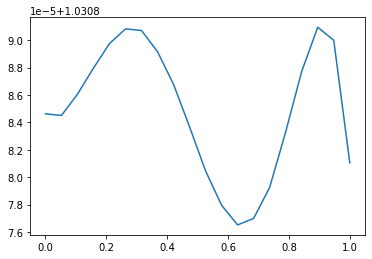

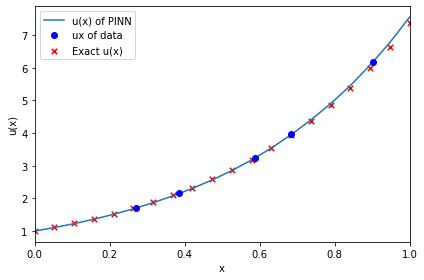

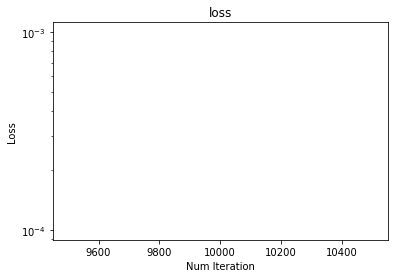

(10001, 0.0009802912)
(10002, 0.0009803035)
(10003, 0.0009802997)
(10004, 0.0009802802)
(10005, 0.0009802477)
(10006, 0.0009802661)
(10007, 0.0009802536)
(10008, 0.0009802375)
(10009, 0.0009801995)
(10010, 0.0009802037)
(10011, 0.000980161)
(10012, 0.0009801376)
(10013, 0.0009801534)
(10014, 0.0009801331)
(10015, 0.0009800954)
(10016, 0.0009800963)
(10017, 0.000980067)
(10018, 0.0009800678)
(10019, 0.0009800649)
(10020, 0.0009800494)
(10021, 0.0009800129)
(10022, 0.0009799802)
(10023, 0.0009800055)
(10024, 0.0009799942)
(10025, 0.0009799554)
(10026, 0.0009799508)
(10027, 0.0009799541)
(10028, 0.0009799384)
(10029, 0.0009799298)
(10030, 0.0009799056)
(10031, 0.0009798657)
(10032, 0.0009798809)
(10033, 0.0009798368)
(10034, 0.0009797923)
(10035, 0.000979808)
(10036, 0.0009798283)
(10037, 0.0009797784)
(10038, 0.0009797772)
(10039, 0.0009797371)
(10040, 0.0009797271)
(10041, 0.0009797319)
(10042, 0.0009796978)
(10043, 0.000979702)
(10044, 0.0009796751)
(10045, 0.0009796481)
(10046, 0.0009

(10375, 0.0010476842)
(10376, 0.0010981272)
(10377, 0.0011851625)
(10378, 0.0013341398)
(10379, 0.0015930088)
(10380, 0.0020319761)
(10381, 0.002787719)
(10382, 0.0040128105)
(10383, 0.005998501)
(10384, 0.008750798)
(10385, 0.012285742)
(10386, 0.014928153)
(10387, 0.015328107)
(10388, 0.011268168)
(10389, 0.00533914)
(10390, 0.0014415324)
(10391, 0.0020548906)
(10392, 0.005345626)
(10393, 0.0073144115)
(10394, 0.005993437)
(10395, 0.0027498193)
(10396, 0.0011208877)
(10397, 0.0022552954)
(10398, 0.0040863906)
(10399, 0.004213548)
(10400, 0.0025103851)
(10401, 0.0011459476)
(10402, 0.0014787592)
(10403, 0.002617987)
(10404, 0.0029060792)
(10405, 0.0019870729)
(10406, 0.0011065428)
(10407, 0.0012271074)
(10408, 0.0019116189)
(10409, 0.0021246453)
(10410, 0.0015933595)
(10411, 0.0010529269)
(10412, 0.0011148166)
(10413, 0.0015306257)
(10414, 0.0016632729)
(10415, 0.0013438024)
(10416, 0.0010167691)
(10417, 0.0010549221)
(10418, 0.0013072569)
(10419, 0.0013874978)
(10420, 0.0011962214)
(

(10745, 0.0009812457)
(10746, 0.00097384653)
(10747, 0.0009752299)
(10748, 0.0009814966)
(10749, 0.0009841782)
(10750, 0.0009798551)
(10751, 0.00097340473)
(10752, 0.0009713583)
(10753, 0.0009746779)
(10754, 0.0009783386)
(10755, 0.0009777675)
(10756, 0.000973664)
(10757, 0.0009706269)
(10758, 0.0009712817)
(10759, 0.00097398245)
(10760, 0.0009751721)
(10761, 0.00097351876)
(10762, 0.0009710018)
(10763, 0.0009701354)
(10764, 0.00097137893)
(10765, 0.00097274076)
(10766, 0.0009726956)
(10767, 0.00097138167)
(10768, 0.0009702439)
(10769, 0.0009702884)
(10770, 0.00097106036)
(10771, 0.0009715039)
(10772, 0.00097118766)
(10773, 0.000970564)
(10774, 0.00097008236)
(10775, 0.00097019295)
(10776, 0.0009705433)
(10777, 0.0009706987)
(10778, 0.00097052247)
(10779, 0.0009702185)
(10780, 0.0009700001)
(10781, 0.0009700297)
(10782, 0.0009701514)
(10783, 0.0009702718)
(10784, 0.00097017305)
(10785, 0.00097008847)
(10786, 0.00096991914)
(10787, 0.00096988835)
(10788, 0.0009699471)
(10789, 0.00096998

(11115, 0.00096605887)
(11116, 0.00096603885)
(11117, 0.00096603413)
(11118, 0.0009660368)
(11119, 0.0009660376)
(11120, 0.0009660023)
(11121, 0.00096599676)
(11122, 0.00096597447)
(11123, 0.0009659769)
(11124, 0.00096594665)
(11125, 0.00096593425)
(11126, 0.00096593105)
(11127, 0.00096591545)
(11128, 0.00096591376)
(11129, 0.00096589624)
(11130, 0.00096587103)
(11131, 0.0009658719)
(11132, 0.0009658751)
(11133, 0.0009658541)
(11134, 0.00096582354)
(11135, 0.00096582866)
(11136, 0.0009658218)
(11137, 0.0009657998)
(11138, 0.0009657737)
(11139, 0.0009657637)
(11140, 0.00096575415)
(11141, 0.000965749)
(11142, 0.0009657487)
(11143, 0.00096573506)
(11144, 0.00096570415)
(11145, 0.0009657345)
(11146, 0.00096569816)
(11147, 0.0009656776)
(11148, 0.00096566585)
(11149, 0.0009656618)
(11150, 0.00096566696)
(11151, 0.0009656215)
(11152, 0.00096562324)
(11153, 0.0009656467)
(11154, 0.0009656115)
(11155, 0.00096562284)
(11156, 0.0009655637)
(11157, 0.00096557615)
(11158, 0.0009655602)
(11159, 0.

(11484, 0.00096209557)
(11485, 0.0009620814)
(11486, 0.00096208544)
(11487, 0.0009620562)
(11488, 0.00096206774)
(11489, 0.00096201553)
(11490, 0.0009620725)
(11491, 0.0009620042)
(11492, 0.0009620107)
(11493, 0.0009620122)
(11494, 0.0009620202)
(11495, 0.0009619992)
(11496, 0.0009619944)
(11497, 0.0009619528)
(11498, 0.00096197776)
(11499, 0.0009619216)
(11500, 0.0009619346)
(11501, 0.00096192665)
(11502, 0.00096188963)
(11503, 0.00096189487)
(11504, 0.00096186623)
(11505, 0.0009618727)
(11506, 0.0009618602)
(11507, 0.00096185255)
(11508, 0.0009618692)
(11509, 0.0009618397)
(11510, 0.0009618273)
(11511, 0.000961806)
(11512, 0.0009618271)
(11513, 0.00096178363)
(11514, 0.000961798)
(11515, 0.0009618058)
(11516, 0.00096175505)
(11517, 0.0009617851)
(11518, 0.00096175453)
(11519, 0.0009617681)
(11520, 0.0009617918)
(11521, 0.00096177316)
(11522, 0.00096177985)
(11523, 0.0009618324)
(11524, 0.00096197514)
(11525, 0.00096209964)
(11526, 0.000962371)
(11527, 0.0009628069)
(11528, 0.00096359

(11853, 0.0027733531)
(11854, 0.0038847513)
(11855, 0.0056152125)
(11856, 0.007891754)
(11857, 0.010694377)
(11858, 0.0126536265)
(11859, 0.012854921)
(11860, 0.009673008)
(11861, 0.0049612513)
(11862, 0.0014836979)
(11863, 0.001360077)
(11864, 0.0037416418)
(11865, 0.0058897417)
(11866, 0.005781391)
(11867, 0.0034546694)
(11868, 0.0013186065)
(11869, 0.0011782999)
(11870, 0.0026007323)
(11871, 0.0037011688)
(11872, 0.003205398)
(11873, 0.0018027714)
(11874, 0.0009833357)
(11875, 0.0013929832)
(11876, 0.0022515748)
(11877, 0.0024425748)
(11878, 0.0018085369)
(11879, 0.0010954146)
(11880, 0.0010320687)
(11881, 0.0015007922)
(11882, 0.0018253952)
(11883, 0.0016267013)
(11884, 0.0011632964)
(11885, 0.0009594332)
(11886, 0.0011522658)
(11887, 0.0014172414)
(11888, 0.0014190114)
(11889, 0.0011732449)
(11890, 0.0009749134)
(11891, 0.00100797)
(11892, 0.0011704239)
(11893, 0.001243282)
(11894, 0.0011471504)
(11895, 0.0010045075)
(11896, 0.00096308097)
(11897, 0.0010358314)
(11898, 0.001113010

(12223, 0.00095693115)
(12224, 0.00095636584)
(12225, 0.00095577125)
(12226, 0.00095571345)
(12227, 0.00095604174)
(12228, 0.0009561908)
(12229, 0.00095592305)
(12230, 0.00095557934)
(12231, 0.00095551135)
(12232, 0.0009556324)
(12233, 0.0009557319)
(12234, 0.0009556049)
(12235, 0.0009554488)
(12236, 0.00095534837)
(12237, 0.00095539674)
(12238, 0.00095544395)
(12239, 0.00095541344)
(12240, 0.00095531996)
(12241, 0.0009552252)
(12242, 0.00095521956)
(12243, 0.00095525343)
(12244, 0.00095527474)
(12245, 0.00095522066)
(12246, 0.0009551458)
(12247, 0.0009551272)
(12248, 0.00095515006)
(12249, 0.0009551317)
(12250, 0.0009551567)
(12251, 0.0009551069)
(12252, 0.0009550525)
(12253, 0.0009550762)
(12254, 0.0009550834)
(12255, 0.00095506303)
(12256, 0.0009550659)
(12257, 0.0009550076)
(12258, 0.00095500576)
(12259, 0.0009549872)
(12260, 0.00095498416)
(12261, 0.0009549628)
(12262, 0.0009549446)
(12263, 0.00095495384)
(12264, 0.00095493667)
(12265, 0.00095492246)
(12266, 0.0009549347)
(12267, 

(12591, 0.000952177)
(12592, 0.00095213426)
(12593, 0.0009520968)
(12594, 0.0009520492)
(12595, 0.0009520547)
(12596, 0.000952097)
(12597, 0.00095207116)
(12598, 0.00095206324)
(12599, 0.0009520721)
(12600, 0.0009520275)
(12601, 0.00095202477)
(12602, 0.0009519979)
(12603, 0.00095199933)
(12604, 0.00095197454)
(12605, 0.0009520127)
(12606, 0.0009519945)
(12607, 0.0009520074)
(12608, 0.00095194293)
(12609, 0.0009519363)
(12610, 0.0009519572)
(12611, 0.0009519154)
(12612, 0.00095192186)
(12613, 0.0009519079)
(12614, 0.00095185806)
(12615, 0.00095189374)
(12616, 0.00095188693)
(12617, 0.000951877)
(12618, 0.00095185736)
(12619, 0.00095183915)
(12620, 0.0009518717)
(12621, 0.0009518448)
(12622, 0.0009518204)
(12623, 0.00095181295)
(12624, 0.0009517938)
(12625, 0.0009518023)
(12626, 0.00095178676)
(12627, 0.00095177745)
(12628, 0.0009517718)
(12629, 0.0009517444)
(12630, 0.0009517297)
(12631, 0.0009517222)
(12632, 0.0009517084)
(12633, 0.0009517546)
(12634, 0.0009517308)
(12635, 0.000951717

(12960, 0.0009490624)
(12961, 0.00094903965)
(12962, 0.0009490751)
(12963, 0.00094904087)
(12964, 0.00094906805)
(12965, 0.00094908994)
(12966, 0.0009491304)
(12967, 0.0009491827)
(12968, 0.00094927964)
(12969, 0.00094943994)
(12970, 0.00094972656)
(12971, 0.0009502366)
(12972, 0.0009510813)
(12973, 0.000952488)
(12974, 0.0009548233)
(12975, 0.0009588537)
(12976, 0.0009657972)
(12977, 0.0009778027)
(12978, 0.0009985687)
(12979, 0.001034899)
(12980, 0.001098321)
(12981, 0.0012103901)
(12982, 0.0014062175)
(12983, 0.0017540021)
(12984, 0.0023525837)
(12985, 0.0033976147)
(12986, 0.005083797)
(12987, 0.007775475)
(12988, 0.0112289535)
(12989, 0.01505673)
(12990, 0.016374482)
(12991, 0.013851472)
(12992, 0.0072870096)
(12993, 0.0019271706)
(12994, 0.0015215838)
(12995, 0.004997948)
(12996, 0.007904435)
(12997, 0.006716746)
(12998, 0.0030672678)
(12999, 0.0010171866)
(13000, 0.0023329947)
(13001, 0.0045327414)
(13002, 0.0044557084)
(13003, 0.0023849136)
(13004, 0.0010064758)
(13005, 0.00174

(13330, 0.0012215304)
(13331, 0.0013448984)
(13332, 0.001952063)
(13333, 0.0020899933)
(13334, 0.0015297356)
(13335, 0.0010209758)
(13336, 0.001217806)
(13337, 0.0016639911)
(13338, 0.0015951479)
(13339, 0.0011616695)
(13340, 0.00100696)
(13341, 0.0012223362)
(13342, 0.0013632048)
(13343, 0.0012413141)
(13344, 0.0010821876)
(13345, 0.0010480151)
(13346, 0.0010977493)
(13347, 0.0011488424)
(13348, 0.0011399417)
(13349, 0.0010577734)
(13350, 0.0009859895)
(13351, 0.001014968)
(13352, 0.0010865554)
(13353, 0.0010763913)
(13354, 0.0009963452)
(13355, 0.0009606125)
(13356, 0.0009986546)
(13357, 0.0010335611)
(13358, 0.0010159239)
(13359, 0.0009768348)
(13360, 0.00096023135)
(13361, 0.00097333145)
(13362, 0.0009934916)
(13363, 0.0009930483)
(13364, 0.00096864306)
(13365, 0.0009492493)
(13366, 0.00095861487)
(13367, 0.0009784668)
(13368, 0.00097649323)
(13369, 0.0009563148)
(13370, 0.0009470024)
(13371, 0.0009561812)
(13372, 0.0009648549)
(13373, 0.0009611727)
(13374, 0.00095306744)
(13375, 0

(13700, 0.00094342895)
(13701, 0.0009438609)
(13702, 0.00094439223)
(13703, 0.000944516)
(13704, 0.0009441456)
(13705, 0.0009436507)
(13706, 0.0009433294)
(13707, 0.0009433993)
(13708, 0.0009436664)
(13709, 0.00094386627)
(13710, 0.00094383745)
(13711, 0.00094358524)
(13712, 0.00094334624)
(13713, 0.00094324705)
(13714, 0.0009433234)
(13715, 0.0009434882)
(13716, 0.0009435168)
(13717, 0.0009434874)
(13718, 0.00094333803)
(13719, 0.0009432227)
(13720, 0.00094321015)
(13721, 0.00094321754)
(13722, 0.00094330614)
(13723, 0.0009433224)
(13724, 0.0009433083)
(13725, 0.0009432262)
(13726, 0.0009431768)
(13727, 0.00094313646)
(13728, 0.0009431464)
(13729, 0.00094314414)
(13730, 0.00094319147)
(13731, 0.000943178)
(13732, 0.0009431406)
(13733, 0.0009431155)
(13734, 0.0009430981)
(13735, 0.0009430919)
(13736, 0.0009431096)
(13737, 0.00094307563)
(13738, 0.00094312377)
(13739, 0.0009430789)
(13740, 0.00094308046)
(13741, 0.00094306417)
(13742, 0.00094300526)
(13743, 0.00094302226)
(13744, 0.0009

(14437, 0.0012311654)
(14438, 0.001135976)
(14439, 0.000985177)
(14440, 0.00094464666)
(14441, 0.0010245331)
(14442, 0.0010995395)
(14443, 0.001077167)
(14444, 0.0009946884)
(14445, 0.0009451447)
(14446, 0.000966143)
(14447, 0.0010136262)
(14448, 0.0010268014)
(14449, 0.0009944149)
(14450, 0.0009536585)
(14451, 0.0009435294)
(14452, 0.00096516067)
(14453, 0.0009873186)
(14454, 0.0009838282)
(14455, 0.00095939444)
(14456, 0.00094045757)
(14457, 0.0009435322)
(14458, 0.0009596477)
(14459, 0.000967695)
(14460, 0.0009590128)
(14461, 0.00094425934)
(14462, 0.0009383439)
(14463, 0.00094411656)
(14464, 0.0009521911)
(14465, 0.0009532423)
(14466, 0.000946996)
(14467, 0.000940202)
(14468, 0.00093866565)
(14469, 0.0009419949)
(14470, 0.0009456943)
(14471, 0.0009458412)
(14472, 0.0009424929)
(14473, 0.0009388792)
(14474, 0.00093795895)
(14475, 0.00093989715)
(14476, 0.00094212167)
(14477, 0.0009421978)
(14478, 0.0009401234)
(14479, 0.00093804783)
(14480, 0.0009375866)
(14481, 0.00093877735)
(1448

(14805, 0.0009349858)
(14806, 0.00093499164)
(14807, 0.0009349672)
(14808, 0.0009349898)
(14809, 0.0009349839)
(14810, 0.0009349683)
(14811, 0.0009349785)
(14812, 0.00093493744)
(14813, 0.00093491626)
(14814, 0.0009349465)
(14815, 0.000934913)
(14816, 0.0009349478)
(14817, 0.00093490136)
(14818, 0.00093489664)
(14819, 0.0009348708)
(14820, 0.0009349036)
(14821, 0.00093485176)
(14822, 0.0009348786)
(14823, 0.00093486835)
(14824, 0.0009348812)
(14825, 0.00093484164)
(14826, 0.00093484716)
(14827, 0.00093483104)
(14828, 0.0009348212)
(14829, 0.00093483756)
(14830, 0.0009348159)
(14831, 0.00093481346)
(14832, 0.0009347773)
(14833, 0.0009347745)
(14834, 0.00093479577)
(14835, 0.0009347639)
(14836, 0.0009347441)
(14837, 0.00093473116)
(14838, 0.0009347662)
(14839, 0.00093475124)
(14840, 0.0009347296)
(14841, 0.00093471614)
(14842, 0.00093470817)
(14843, 0.0009347018)
(14844, 0.0009347284)
(14845, 0.00093470636)
(14846, 0.0009346914)
(14847, 0.00093468244)
(14848, 0.0009346913)
(14849, 0.0009

(15174, 0.0009322243)
(15175, 0.00093220326)
(15176, 0.0009321971)
(15177, 0.0009322092)
(15178, 0.0009321765)
(15179, 0.00093215896)
(15180, 0.00093217846)
(15181, 0.00093215273)
(15182, 0.00093214045)
(15183, 0.00093215186)
(15184, 0.00093214546)
(15185, 0.00093213073)
(15186, 0.0009321264)
(15187, 0.0009320973)
(15188, 0.0009321083)
(15189, 0.0009320892)
(15190, 0.00093210593)
(15191, 0.0009320972)
(15192, 0.00093207485)
(15193, 0.00093209697)
(15194, 0.0009320997)
(15195, 0.0009320573)
(15196, 0.0009320508)
(15197, 0.00093205797)
(15198, 0.00093201495)
(15199, 0.00093201734)
(15200, 0.00093202037)
(15201, 0.00093203934)
(15202, 0.0009320137)
(15203, 0.00093199714)
(15204, 0.0009320127)
(15205, 0.0009319818)
(15206, 0.0009319435)
(15207, 0.0009319661)
(15208, 0.0009319405)
(15209, 0.0009319372)
(15210, 0.00093195424)
(15211, 0.00093191816)
(15212, 0.00093192596)
(15213, 0.00093190407)
(15214, 0.00093192083)
(15215, 0.00093193946)
(15216, 0.0009319241)
(15217, 0.0009319433)
(15218, 0

(15910, 0.00092660304)
(15911, 0.0009265891)
(15912, 0.0009266105)
(15913, 0.00092656567)
(15914, 0.0009265977)
(15915, 0.00092653563)
(15916, 0.00092658476)
(15917, 0.0009265523)
(15918, 0.000926568)
(15919, 0.00092655205)
(15920, 0.0009265251)
(15921, 0.00092652795)
(15922, 0.00092654134)
(15923, 0.00092652056)
(15924, 0.00092649006)
(15925, 0.00092651433)
(15926, 0.0009264761)
(15927, 0.00092646456)
(15928, 0.0009264913)
(15929, 0.00092645176)
(15930, 0.0009264557)
(15931, 0.0009264885)
(15932, 0.0009264479)
(15933, 0.0009264268)
(15934, 0.0009264355)
(15935, 0.0009264263)
(15936, 0.00092641596)
(15937, 0.0009264448)
(15938, 0.0009263968)
(15939, 0.00092636154)
(15940, 0.0009263976)
(15941, 0.0009264021)
(15942, 0.000926401)
(15943, 0.0009264049)
(15944, 0.00092641305)
(15945, 0.00092642225)
(15946, 0.00092643907)
(15947, 0.0009264942)
(15948, 0.0009265232)
(15949, 0.0009265967)
(15950, 0.0009267231)
(15951, 0.000926939)
(15952, 0.0009272079)
(15953, 0.0009276333)
(15954, 0.00092838

(16647, 0.0009208516)
(16648, 0.000920883)
(16649, 0.00092084747)
(16650, 0.0009208137)
(16651, 0.00092085334)
(16652, 0.0009208374)
(16653, 0.0009208286)
(16654, 0.00092079816)
(16655, 0.0009207939)
(16656, 0.00092079723)
(16657, 0.00092081784)
(16658, 0.0009207909)
(16659, 0.00092075806)
(16660, 0.0009207929)
(16661, 0.0009207593)
(16662, 0.0009207491)
(16663, 0.00092071726)
(16664, 0.00092076184)
(16665, 0.00092072546)
(16666, 0.0009207104)
(16667, 0.00092072476)
(16668, 0.000920702)
(16669, 0.0009206876)
(16670, 0.000920692)
(16671, 0.00092067954)
(16672, 0.00092067505)
(16673, 0.00092066673)
(16674, 0.0009206764)
(16675, 0.0009206484)
(16676, 0.0009205919)
(16677, 0.0009206414)
(16678, 0.00092062325)
(16679, 0.00092062214)
(16680, 0.0009206185)
(16681, 0.00092062267)
(16682, 0.0009205781)
(16683, 0.0009206018)
(16684, 0.0009205973)
(16685, 0.0009205548)
(16686, 0.0009205911)
(16687, 0.0009205654)
(16688, 0.00092055945)
(16689, 0.0009205391)
(16690, 0.00092052296)
(16691, 0.0009205

(17384, 0.0009149879)
(17385, 0.00091487035)
(17386, 0.00091491453)
(17387, 0.00091486255)
(17388, 0.0009148188)
(17389, 0.0009148684)
(17390, 0.0009148746)
(17391, 0.00091489597)
(17392, 0.0009148644)
(17393, 0.0009148384)
(17394, 0.00091482134)
(17395, 0.0009147943)
(17396, 0.00091476686)
(17397, 0.0009148099)
(17398, 0.00091476185)
(17399, 0.0009147591)
(17400, 0.0009148021)
(17401, 0.0009147309)
(17402, 0.00091472623)
(17403, 0.00091471727)
(17404, 0.0009147026)
(17405, 0.00091472093)
(17406, 0.0009147202)
(17407, 0.0009147139)
(17408, 0.0009146758)
(17409, 0.0009146834)
(17410, 0.0009146844)
(17411, 0.00091462577)
(17412, 0.0009146559)
(17413, 0.00091463083)
(17414, 0.0009146035)
(17415, 0.0009146384)
(17416, 0.00091462885)
(17417, 0.00091462646)
(17418, 0.0009146289)
(17419, 0.00091460213)
(17420, 0.000914618)
(17421, 0.0009145847)
(17422, 0.00091456174)
(17423, 0.00091456)
(17424, 0.00091456535)
(17425, 0.000914542)
(17426, 0.0009145345)
(17427, 0.0009145455)
(17428, 0.000914518

(17752, 0.000911732)
(17753, 0.00091174326)
(17754, 0.00091171433)
(17755, 0.0009117317)
(17756, 0.0009117256)
(17757, 0.0009117253)
(17758, 0.00091172993)
(17759, 0.00091167795)
(17760, 0.00091168855)
(17761, 0.00091167353)
(17762, 0.00091169856)
(17763, 0.00091164745)
(17764, 0.0009116454)
(17765, 0.0009116685)
(17766, 0.0009116112)
(17767, 0.00091161643)
(17768, 0.0009116032)
(17769, 0.0009116639)
(17770, 0.00091158086)
(17771, 0.000911616)
(17772, 0.00091158925)
(17773, 0.00091159646)
(17774, 0.0009116256)
(17775, 0.00091159425)
(17776, 0.00091162696)
(17777, 0.0009116326)
(17778, 0.00091165793)
(17779, 0.00091169996)
(17780, 0.0009117802)
(17781, 0.0009118768)
(17782, 0.0009119856)
(17783, 0.00091222575)
(17784, 0.0009125561)
(17785, 0.0009130504)
(17786, 0.0009138045)
(17787, 0.00091493875)
(17788, 0.0009167134)
(17789, 0.0009194977)
(17790, 0.0009237916)
(17791, 0.00093051686)
(17792, 0.00094111107)
(17793, 0.00095796224)
(17794, 0.0009847848)
(17795, 0.0010279781)
(17796, 0.001

(18122, 0.000908995)
(18123, 0.00090910145)
(18124, 0.0009090372)
(18125, 0.000908786)
(18126, 0.000908563)
(18127, 0.00090845744)
(18128, 0.00090848055)
(18129, 0.00090856233)
(18130, 0.00090864516)
(18131, 0.0009086445)
(18132, 0.00090862456)
(18133, 0.00090849405)
(18134, 0.00090842915)
(18135, 0.00090839015)
(18136, 0.00090835354)
(18137, 0.00090840406)
(18138, 0.0009083955)
(18139, 0.0009083884)
(18140, 0.00090844586)
(18141, 0.00090837246)
(18142, 0.0009083209)
(18143, 0.0009082811)
(18144, 0.0009082852)
(18145, 0.00090826233)
(18146, 0.00090829516)
(18147, 0.0009082869)
(18148, 0.00090827246)
(18149, 0.00090831245)
(18150, 0.0009082536)
(18151, 0.0009082165)
(18152, 0.0009082054)
(18153, 0.0009081904)
(18154, 0.00090817234)
(18155, 0.0009081764)
(18156, 0.0009081741)
(18157, 0.0009081747)
(18158, 0.0009081668)
(18159, 0.0009081482)
(18160, 0.0009081274)
(18161, 0.0009081383)
(18162, 0.00090813957)
(18163, 0.00090809306)
(18164, 0.00090809073)
(18165, 0.0009080502)
(18166, 0.0009

(18490, 0.0009148187)
(18491, 0.0009200566)
(18492, 0.0009282761)
(18493, 0.0009412841)
(18494, 0.00096214836)
(18495, 0.0009953728)
(18496, 0.0010492727)
(18497, 0.0011357081)
(18498, 0.0012770918)
(18499, 0.001502756)
(18500, 0.001871145)
(18501, 0.0024421404)
(18502, 0.0033441395)
(18503, 0.004615952)
(18504, 0.0063942377)
(18505, 0.0082625495)
(18506, 0.009912702)
(18507, 0.009901707)
(18508, 0.008086742)
(18509, 0.0046966616)
(18510, 0.001863634)
(18511, 0.0010611155)
(18512, 0.0022447803)
(18513, 0.0039995476)
(18514, 0.004648614)
(18515, 0.0037342808)
(18516, 0.0020255516)
(18517, 0.0010242221)
(18518, 0.001338585)
(18519, 0.0023108905)
(18520, 0.0028339112)
(18521, 0.0023770218)
(18522, 0.0014786501)
(18523, 0.0009751948)
(18524, 0.0011923448)
(18525, 0.0017102311)
(18526, 0.0019121523)
(18527, 0.001625876)
(18528, 0.0011599088)
(18529, 0.0009502133)
(18530, 0.0011034759)
(18531, 0.001369855)
(18532, 0.0014473826)
(18533, 0.0012606181)
(18534, 0.0010098856)
(18535, 0.0009222639

(18860, 0.000901636)
(18861, 0.0009016078)
(18862, 0.0009016005)
(18863, 0.00090156)
(18864, 0.0009015538)
(18865, 0.0009015649)
(18866, 0.00090152666)
(18867, 0.0009015654)
(18868, 0.0009015423)
(18869, 0.000901527)
(18870, 0.0009015295)
(18871, 0.0009015031)
(18872, 0.0009014821)
(18873, 0.0009014781)
(18874, 0.0009014765)
(18875, 0.00090147706)
(18876, 0.00090143667)
(18877, 0.00090144586)
(18878, 0.0009014289)
(18879, 0.0009014386)
(18880, 0.0009014272)
(18881, 0.0009014162)
(18882, 0.00090137724)
(18883, 0.0009013819)
(18884, 0.00090136804)
(18885, 0.0009013667)
(18886, 0.0009013539)
(18887, 0.000901378)
(18888, 0.0009013566)
(18889, 0.00090132875)
(18890, 0.000901331)
(18891, 0.0009012872)
(18892, 0.00090130925)
(18893, 0.00090127665)
(18894, 0.0009012783)
(18895, 0.00090125785)
(18896, 0.00090126507)
(18897, 0.000901269)
(18898, 0.00090124033)
(18899, 0.0009012517)
(18900, 0.00090126303)
(18901, 0.00090122595)
(18902, 0.00090122456)
(18903, 0.0009011726)
(18904, 0.0009011808)
(1

(19599, 0.0010264564)
(19600, 0.0010601444)
(19601, 0.0009772652)
(19602, 0.0009002051)
(19603, 0.00092104595)
(19604, 0.0009847448)
(19605, 0.0009905316)
(19606, 0.0009341802)
(19607, 0.00089564594)
(19608, 0.0009162086)
(19609, 0.00095232367)
(19610, 0.0009491672)
(19611, 0.00091412076)
(19612, 0.00089520105)
(19613, 0.0009100785)
(19614, 0.00092982425)
(19615, 0.0009254506)
(19616, 0.00090499653)
(19617, 0.00089550356)
(19618, 0.00090455945)
(19619, 0.00091498706)
(19620, 0.00091204525)
(19621, 0.0009009019)
(19622, 0.00089573883)
(19623, 0.00090012484)
(19624, 0.0009056552)
(19625, 0.0009046045)
(19626, 0.0008989623)
(19627, 0.00089560717)
(19628, 0.000897095)
(19629, 0.00090011884)
(19630, 0.0009003622)
(19631, 0.0008977236)
(19632, 0.0008953246)
(19633, 0.0008953677)
(19634, 0.00089698815)
(19635, 0.0008978012)
(19636, 0.00089676376)
(19637, 0.00089509087)
(19638, 0.00089454284)
(19639, 0.00089528237)
(19640, 0.00089610304)
(19641, 0.0008959073)
(19642, 0.0008949363)
(19643, 0.00

(19968, 0.0008913498)
(19969, 0.0008912922)
(19970, 0.00089099363)
(19971, 0.0008907513)
(19972, 0.0008907336)
(19973, 0.00089083094)
(19974, 0.00089098315)
(19975, 0.00089099555)
(19976, 0.000890902)
(19977, 0.0008907533)
(19978, 0.0008906438)
(19979, 0.0008906418)
(19980, 0.00089073967)
(19981, 0.0008907434)
(19982, 0.00089075894)
(19983, 0.00089070876)
(19984, 0.0008906248)
(19985, 0.0008905501)
(19986, 0.0008905682)
(19987, 0.00089064165)
(19988, 0.0008906237)
(19989, 0.0008906276)
(19990, 0.0008905739)
(19991, 0.0008905275)
(19992, 0.0008904978)
(19993, 0.00089050067)
(19994, 0.00089055166)
(19995, 0.0008905225)
(19996, 0.00089052424)
(19997, 0.00089050765)
(19998, 0.0008904806)
(19999, 0.0008904547)
(20000, 0.000890436)
Time:  20.937139987945557
Result Plotted...
L2U error:  0.015213358200162458
L2LM error:  0.0019964198355062117
[[0.       1.001998 1.       1.       0.995371]
 [0.052632 1.001995 1.       1.111003 1.103332]
 [0.105263 1.001995 1.       1.234328 1.223689]
 [0.1578

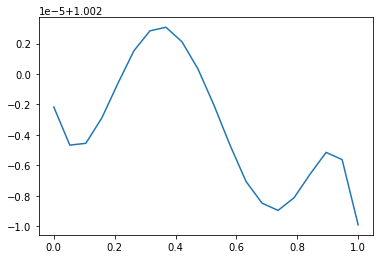

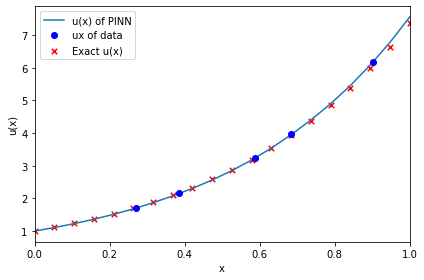

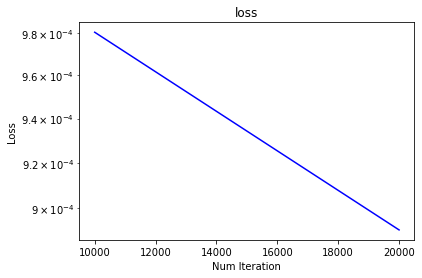

In [2]:

def ElasImag(nIter = 20000, print_period = 1000, plot_period = 1000):
    x_range = np.array([a, b])
    # Network Structure
    layers_U = [1, 20, 20, 20,1]
    layers_V1 = [1, 20, 20, 20, 1]
    layers_V2 = [1, 20, 20, 20, 1]
    layers_V3 = [1, 20, 20, 20, 1]
    layers_V4 = [1, 20, 20, 20, 1]
    layers_LM = [1, 20, 1]

    Xx, Ux = import_data('U_exact.txt')

    f = open("loss_record.txt", "w")

    num_train_tps = 200
    num_test_tps =20

    model = PhysicsInformedNN(layers_U, layers_V1,layers_V2,layers_V3,layers_V4,layers_LM, x_range, f, num_train_tps)

    it_array = []
    loss_array = []
    losses_array = []

    start_time = time.time()
    for it in range(1, nIter+1):
        loss, losses = model.train(Xx, Ux, it, it%print_period==0)
        if (it%print_period==0):
            loss_array.append(loss)
            losses_array.append(losses)
            it_array.append(it)
            dt = time.time() - start_time
            print('Time: ', dt)
            start_time = time.time()
            if (it % plot_period == 0 or it == print_period):
                print("Result Plotted...")
                plt.figure(1)
                x_test, U_test, V1_test, V2_test, V3_test,V4_test,_, _, _, _, _, _, _,_,_,_,LM_test = model.test(num_test_tps)
                u_exact = np.exp(2*x_test)
                LM_exact = 1 * np.ones(LM_test.shape)
                l2Uerror = np.linalg.norm(U_test - u_exact, 2) / np.linalg.norm(u_exact, 2)
                l2LMerror = np.linalg.norm(LM_test - LM_exact, 2) / np.linalg.norm(LM_exact, 2)
                print('L2U error: ', l2Uerror)
                print('L2LM error: ', l2LMerror)
                xx = Xx[:, 0:1]
                ux = Ux[:, 0:1]
                U = np.hstack((x_test, LM_test, LM_exact, u_exact, U_test))
                print(U)
                plt.plot(x_test, LM_test, label='LM_test of PINN')
                plt.figure()
                plt.plot(x_test, U_test, label='u(x) of PINN')
                plt.scatter(x_test, u_exact, s=30, c='r', marker='x', label='Exact u(x)')
                plt.plot(xx, ux, c='b', linestyle='' ' ', marker='o', label='ux of data')
                plt.legend(loc='upper left')
                plt.xlabel('x')
                plt.ylabel('u(x)')
                plt.xlim(x_range[0], x_range[1])
                plt.tight_layout()
                plt.show()
                figtopic = 'loss'
                plt.semilogy(it_array, loss_array, '-b')
                plt.xlabel("Num Iteration")
                plt.ylabel("Loss")
                plt.title(figtopic)
                plt.show()
ElasImag(nIter =20000, print_period =10000, plot_period =10000)